In [1]:
import pickle
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc
from timeit import default_timer as timer
# needed to see images
from IPython.display import display, Image
import pickle
from sklearn.preprocessing import LabelBinarizer

# needed for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
current_palette = sns.color_palette()

In [2]:
# Requires TensorFlow V.12
tf.__version__

'0.12.0-rc1'

In [3]:
data = pickle.load(open('193_features.p', 'rb'))

In [4]:
s = list(data['sample'])
s = pd.DataFrame(s)
data_cols = s.columns
s['label'] = data['label']
print('working dataframe\'s shape:', s.shape)

working dataframe's shape: (8730, 194)


In [5]:
test_preds = {}
train = s[0:6984]
test = s[6984:]
LB = LabelBinarizer().fit(train['label'])
test_labels = LB.transform(test['label'])
train_labels = LB.transform(train['label'])

# truncate data
#data_cols = data_cols[:1000]

# print shapes
print('train shape {}\ntest  shape {}\ncommon factors: 1, 2, 3, 6, 9, 18, 97, 194, 291, 582, 873, 1746'.format(train.shape, test.shape))

train shape (6984, 194)
test  shape (1746, 194)
common factors: 1, 2, 3, 6, 9, 18, 97, 194, 291, 582, 873, 1746


In [15]:
all_train_labels = LB.transform(train['label'])

In [17]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.01)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def test_accuracy(session, test_data=test, test_labels=test_labels, during = True):
    test_data.reset_index(inplace=True, drop=True)
    epoch_pred = session.run(prediction, feed_dict={tf_data : test_data.loc[0:check_size-1,data_cols], keep_prob : 1.0})
    for i in range(check_size, test_data.shape[0], check_size):
        epoch_pred = np.concatenate([epoch_pred, session.run(prediction, 
                                    feed_dict={tf_data : test_data.loc[i:i+check_size-1,data_cols], keep_prob : 1.0})], axis=0)
    if during:
        return accuracy(epoch_pred, test_labels)
    else:
        return epoch_pred

## Run Session

In [21]:
num_labels = 10
batch_size = 97
acc_over_time = {}
def Run_Session(num_epochs, name, k_prob=1.0, mute=False, record=False):
    global train
    
    start = timer()
    with tf.Session(graph=graph) as session:
        if record:
            merged = tf.merge_all_summaries()  
            writer = tf.train.SummaryWriter("/tmp/tensorflowlogs", session.graph)
        #tf.initialize_all_variables().run()
        tf.global_variables_initializer().run()

        print("Initialized")
        accu_tr = []
        accu_ts = []
        
        for epoch in range(num_epochs):
            
            # get batch
            train_batch = train.sample(batch_size)
            
            t_d = train_batch[data_cols]
            t_l = LB.transform(train_batch['label'])
            
            # make feed dict
            feed_dict = { tf_data : t_d, train_labels : t_l, keep_prob : k_prob}
            
            # run model on batch
            _, l, predictions = session.run([optimizer, loss, prediction], feed_dict=feed_dict)
            
            # mid model accuracy checks 
            if (epoch % 1000 == 0) and not mute:
                print("\tMinibatch loss at epoch {}: {}".format(epoch, l))
                print("\tMinibatch accuracy: {:.1f}".format(accuracy(predictions, t_l)))
            if (epoch % 5000 == 0) and not mute:
                print("Test accuracy: {:.1f}".format(test_accuracy(session, during=True)))
            if (epoch % 1000 == 0):
                accu_ts.append(tuple([epoch, test_accuracy(session,  during=True)]))
                accu_tr.append(tuple([epoch, test_accuracy(session, test_data=train, test_labels=all_train_labels,  during=True)]))
                
                
        # record accuracy and predictions
        test_preds[name] = test_accuracy(session, during=False)
        print("Final Test accuracy: {:.1f}".format(accuracy(test_preds[name], test_labels)))
        end = timer()
        test_preds[name] = test_preds[name].ravel()
        acc_over_time[name] = (accu_tr, accu_ts)
        print("time taken: {0} minutes {1:.1f} seconds".format((end - start)//60, (end - start)%60))
        #tf.train.export_meta_graph()

## DeepNN

In [22]:
# constants
num_labels = 10

batch_size = 97
check_size = 582
feature_size = 193

n_hidden1 = 400
n_hidden2 = 500
n_hidden3 = 400

beta = 0.01

graph = tf.Graph()
with graph.as_default():
    # placeholders
    tf_data = tf.placeholder(tf.float32, shape=[None, feature_size])
    train_labels = tf.placeholder(tf.float32, shape=[None, num_labels])
    #test_data = tf.placeholder(tf.float32, shape=[batch_size, feature_size, 1])
    keep_prob = tf.placeholder(tf.float32)
    
    # weights and biases
    layer1_weights = weight_variable([feature_size, n_hidden1])
    layer1_biases = bias_variable([n_hidden1])
    layer2_weights = weight_variable([n_hidden1, n_hidden2])
    layer2_biases = bias_variable([n_hidden2])
    layer3_weights = weight_variable([n_hidden2, n_hidden3])
    layer3_biases = bias_variable([n_hidden3])
    layer4_weights = weight_variable([n_hidden3, num_labels])
    layer4_biases = bias_variable([num_labels])

    # model
    def model(data, proba=1.0):
        layer1 = tf.nn.relu(tf.matmul(data, layer1_weights) + layer1_biases)
        layer1 = tf.nn.dropout(layer1, proba)
        
        layer2 = tf.nn.relu(tf.matmul(layer1, layer2_weights) + layer2_biases)
        layer2 = tf.nn.dropout(layer2, proba)
        
        layer3 = tf.nn.relu(tf.matmul(layer2, layer3_weights) + layer3_biases)
        layer3 = tf.nn.dropout(layer3, proba)
        
        return tf.matmul(layer3, layer4_weights) + layer4_biases

    # Training computation.
    logits = model(tf_data, keep_prob)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, train_labels) +
                         beta*tf.nn.l2_loss(layer1_weights) +
                         beta*tf.nn.l2_loss(layer1_biases) +
                         beta*tf.nn.l2_loss(layer2_weights) +
                         beta*tf.nn.l2_loss(layer2_biases) +
                         beta*tf.nn.l2_loss(layer3_weights) +
                         beta*tf.nn.l2_loss(layer3_biases) +
                         beta*tf.nn.l2_loss(layer4_weights) +
                         beta*tf.nn.l2_loss(layer4_biases))

    # Optimizer.
    optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)

    # Predictions for the training, validation, and test data.
    # !!!! as this RNN model does not allow calling model more than once we will need to get test predictions
    #      by running the test data through the same prediction op as the train data. !!!
    # !!! make note to not run optimizer on same function call !!!
    prediction = tf.nn.softmax(logits)
    ### test_prediction = tf.nn.softmax(model(test_data))  
    print('Basic DeepNN model made')

Basic DeepNN model made


In [23]:
train = s[0:1000]
Run_Session(15000, 'NN1', .2)

Initialized
	Minibatch loss at epoch 0: 2.5593013763427734
	Minibatch accuracy: 10.3
Test accuracy: 15.4
	Minibatch loss at epoch 1000: 1.0006884336471558
	Minibatch accuracy: 71.1
	Minibatch loss at epoch 2000: 0.7601749897003174
	Minibatch accuracy: 83.5
	Minibatch loss at epoch 3000: 0.572405993938446
	Minibatch accuracy: 86.6
	Minibatch loss at epoch 4000: 0.5595899820327759
	Minibatch accuracy: 92.8
	Minibatch loss at epoch 5000: 0.4374285042285919
	Minibatch accuracy: 93.8
Test accuracy: 44.4
	Minibatch loss at epoch 6000: 0.35475191473960876
	Minibatch accuracy: 96.9
	Minibatch loss at epoch 7000: 0.3784990906715393
	Minibatch accuracy: 96.9
	Minibatch loss at epoch 8000: 0.35881850123405457
	Minibatch accuracy: 96.9
	Minibatch loss at epoch 9000: 0.393671452999115
	Minibatch accuracy: 94.8
	Minibatch loss at epoch 10000: 0.416215181350708
	Minibatch accuracy: 95.9
Test accuracy: 45.6
	Minibatch loss at epoch 11000: 0.34918534755706787
	Minibatch accuracy: 96.9
	Minibatch loss a

In [25]:
train = s[0:2000]
all_train_labels = LB.transform(train['label'])
Run_Session(15000, 'NN2', .2)

Initialized
	Minibatch loss at epoch 0: 2.541362762451172
	Minibatch accuracy: 12.4
Test accuracy: 9.7
	Minibatch loss at epoch 1000: 1.2692935466766357
	Minibatch accuracy: 61.9
	Minibatch loss at epoch 2000: 1.1614092588424683
	Minibatch accuracy: 62.9
	Minibatch loss at epoch 3000: 0.8936765193939209
	Minibatch accuracy: 75.3
	Minibatch loss at epoch 4000: 0.6921194791793823
	Minibatch accuracy: 84.5
	Minibatch loss at epoch 5000: 0.6170809268951416
	Minibatch accuracy: 88.7
Test accuracy: 48.4
	Minibatch loss at epoch 6000: 0.6725472807884216
	Minibatch accuracy: 85.6
	Minibatch loss at epoch 7000: 0.6079206466674805
	Minibatch accuracy: 89.7
	Minibatch loss at epoch 8000: 0.5695197582244873
	Minibatch accuracy: 93.8
	Minibatch loss at epoch 9000: 0.5066466331481934
	Minibatch accuracy: 91.8
	Minibatch loss at epoch 10000: 0.6297001242637634
	Minibatch accuracy: 89.7
Test accuracy: 50.1
	Minibatch loss at epoch 11000: 0.502411961555481
	Minibatch accuracy: 96.9
	Minibatch loss at e

In [26]:
train = s[0:3000]
all_train_labels = LB.transform(train['label'])
Run_Session(15000, 'NN3', .2)

Initialized
	Minibatch loss at epoch 0: 2.555690050125122
	Minibatch accuracy: 13.4
Test accuracy: 11.7
	Minibatch loss at epoch 1000: 1.5344635248184204
	Minibatch accuracy: 49.5
	Minibatch loss at epoch 2000: 1.1869713068008423
	Minibatch accuracy: 66.0
	Minibatch loss at epoch 3000: 0.9844298958778381
	Minibatch accuracy: 70.1
	Minibatch loss at epoch 4000: 0.8521890044212341
	Minibatch accuracy: 80.4
	Minibatch loss at epoch 5000: 0.8478661179542542
	Minibatch accuracy: 79.4
Test accuracy: 48.3
	Minibatch loss at epoch 6000: 0.8055051565170288
	Minibatch accuracy: 81.4
	Minibatch loss at epoch 7000: 0.7777283787727356
	Minibatch accuracy: 84.5
	Minibatch loss at epoch 8000: 0.8716806769371033
	Minibatch accuracy: 81.4
	Minibatch loss at epoch 9000: 0.6980472803115845
	Minibatch accuracy: 86.6
	Minibatch loss at epoch 10000: 0.659508228302002
	Minibatch accuracy: 87.6
Test accuracy: 50.7
	Minibatch loss at epoch 11000: 0.5777111649513245
	Minibatch accuracy: 89.7
	Minibatch loss at 

In [27]:
train = s[0:4000]
all_train_labels = LB.transform(train['label'])
Run_Session(15000, 'NN4', .2)

Initialized
	Minibatch loss at epoch 0: 2.5357611179351807
	Minibatch accuracy: 15.5
Test accuracy: 11.4
	Minibatch loss at epoch 1000: 1.4957135915756226
	Minibatch accuracy: 50.5
	Minibatch loss at epoch 2000: 1.2967299222946167
	Minibatch accuracy: 60.8
	Minibatch loss at epoch 3000: 1.2487434148788452
	Minibatch accuracy: 62.9
	Minibatch loss at epoch 4000: 0.9995276927947998
	Minibatch accuracy: 73.2
	Minibatch loss at epoch 5000: 0.819800853729248
	Minibatch accuracy: 79.4
Test accuracy: 54.0
	Minibatch loss at epoch 6000: 0.7023181915283203
	Minibatch accuracy: 82.5
	Minibatch loss at epoch 7000: 0.9081413745880127
	Minibatch accuracy: 81.4
	Minibatch loss at epoch 8000: 0.8732615113258362
	Minibatch accuracy: 82.5
	Minibatch loss at epoch 9000: 0.7105173468589783
	Minibatch accuracy: 88.7
	Minibatch loss at epoch 10000: 0.7534568905830383
	Minibatch accuracy: 81.4
Test accuracy: 55.6
	Minibatch loss at epoch 11000: 0.619098961353302
	Minibatch accuracy: 94.8
	Minibatch loss at 

In [28]:
train = s[0:5000]
all_train_labels = LB.transform(train['label'])
Run_Session(15000, 'NN5', .2)

Initialized
	Minibatch loss at epoch 0: 2.5689339637756348
	Minibatch accuracy: 6.2
Test accuracy: 12.7
	Minibatch loss at epoch 1000: 1.7042930126190186
	Minibatch accuracy: 44.3
	Minibatch loss at epoch 2000: 1.5084518194198608
	Minibatch accuracy: 51.5
	Minibatch loss at epoch 3000: 1.1486334800720215
	Minibatch accuracy: 66.0
	Minibatch loss at epoch 4000: 1.3284399509429932
	Minibatch accuracy: 67.0
	Minibatch loss at epoch 5000: 1.0170173645019531
	Minibatch accuracy: 76.3
Test accuracy: 56.8
	Minibatch loss at epoch 6000: 0.9745178818702698
	Minibatch accuracy: 76.3
	Minibatch loss at epoch 7000: 0.8288687467575073
	Minibatch accuracy: 89.7
	Minibatch loss at epoch 8000: 0.8551123142242432
	Minibatch accuracy: 80.4
	Minibatch loss at epoch 9000: 0.923401415348053
	Minibatch accuracy: 83.5
	Minibatch loss at epoch 10000: 0.9091646671295166
	Minibatch accuracy: 80.4
Test accuracy: 59.0
	Minibatch loss at epoch 11000: 0.8447104096412659
	Minibatch accuracy: 83.5
	Minibatch loss at 

In [29]:
train = s[0:6000]
all_train_labels = LB.transform(train['label'])
Run_Session(15000, 'NN6', .2)

Initialized
	Minibatch loss at epoch 0: 2.5856266021728516
	Minibatch accuracy: 10.3
Test accuracy: 15.6
	Minibatch loss at epoch 1000: 1.5560860633850098
	Minibatch accuracy: 40.2
	Minibatch loss at epoch 2000: 1.3447009325027466
	Minibatch accuracy: 59.8
	Minibatch loss at epoch 3000: 1.3998777866363525
	Minibatch accuracy: 58.8
	Minibatch loss at epoch 4000: 1.273011326789856
	Minibatch accuracy: 63.9
	Minibatch loss at epoch 5000: 1.171311378479004
	Minibatch accuracy: 68.0
Test accuracy: 55.7
	Minibatch loss at epoch 6000: 0.8964895606040955
	Minibatch accuracy: 81.4
	Minibatch loss at epoch 7000: 1.1722732782363892
	Minibatch accuracy: 70.1
	Minibatch loss at epoch 8000: 0.9748114347457886
	Minibatch accuracy: 74.2
	Minibatch loss at epoch 9000: 0.8501774072647095
	Minibatch accuracy: 81.4
	Minibatch loss at epoch 10000: 1.0822762250900269
	Minibatch accuracy: 72.2
Test accuracy: 58.0
	Minibatch loss at epoch 11000: 0.8205232620239258
	Minibatch accuracy: 78.4
	Minibatch loss at 

In [30]:
train = s[0:6984]
all_train_labels = LB.transform(train['label'])
Run_Session(15000, 'NN6984', .2)

Initialized
	Minibatch loss at epoch 0: 2.5555975437164307
	Minibatch accuracy: 12.4
Test accuracy: 11.1
	Minibatch loss at epoch 1000: 1.5845431089401245
	Minibatch accuracy: 49.5
	Minibatch loss at epoch 2000: 1.2751085758209229
	Minibatch accuracy: 58.8
	Minibatch loss at epoch 3000: 1.2701315879821777
	Minibatch accuracy: 63.9
	Minibatch loss at epoch 4000: 1.1201924085617065
	Minibatch accuracy: 67.0
	Minibatch loss at epoch 5000: 1.0576838254928589
	Minibatch accuracy: 75.3
Test accuracy: 57.2
	Minibatch loss at epoch 6000: 1.198064923286438
	Minibatch accuracy: 69.1
	Minibatch loss at epoch 7000: 1.0338197946548462
	Minibatch accuracy: 72.2
	Minibatch loss at epoch 8000: 0.980186939239502
	Minibatch accuracy: 81.4
	Minibatch loss at epoch 9000: 0.994850218296051
	Minibatch accuracy: 76.3
	Minibatch loss at epoch 10000: 1.0451939105987549
	Minibatch accuracy: 74.2
Test accuracy: 60.5
	Minibatch loss at epoch 11000: 1.017863154411316
	Minibatch accuracy: 74.2
	Minibatch loss at ep

In [ ]:
plt.plot(np.array(acc_over_time[''])[:,0], np.array(acc_over_time['RNN'])[:,1])
plt.plot(np.array(acc_over_time['D'])[:,0], np.array(acc_over_time['DeepNN'])[:,1])
plt.plot(np.array(acc_over_time['CNN'])[:,0], np.array(acc_over_time['CNN'])[:,1])
plt.title('Accuracy')
plt.show()

In [38]:
np.array(acc_over_time['NN1'])[:,14,1]

array([ 99.8       ,  45.64719359])

In [44]:
t_curve = []
names = ['NN1', 'NN2', 'NN3', 'NN4', 'NN5', 'NN6', 'NN6984']
for name in names:
    t_curve.append(list(np.array(acc_over_time[name])[:,14,1]))

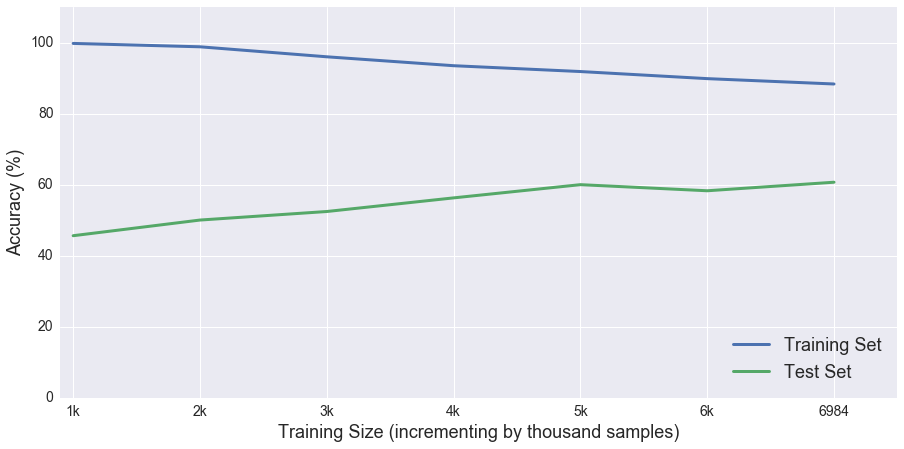

In [67]:
fig = plt.figure(figsize=[15,7])
ticks = ['1k', '2k', '3k', '4k', '5k', '6k', '6984']
plt.plot(np.array(t_curve)[:,0], label='Training Set', linewidth=3)
plt.plot(np.array(t_curve)[:,1], label='Test Set', linewidth=3)
plt.xlabel('Training Size (incrementing by thousand samples)', fontsize=18)
plt.xticks(range(7), ticks, fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=18)
plt.ylim([0, 110])
plt.xlim([-0.1, 6.5])
plt.legend(loc="lower right", fontsize=18)
plt.show()